# Cardio Vascular Disease (CVD) analysis


The dataset has 70,000 records of patients' data in 12 features. The target class 'cardio' equals 1, when a patient has cardiovascular disease, and 0, if a patient is healthy.

The task is to predict the presence or absence of cardiovascular disease (CVD) using the patients' objective and examinations input features.

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_roc_curve, roc_auc_score, f1_score
pd.set_option('precision', 3)
df = pd.read_csv('https://raw.githubusercontent.com/Kuaranir/Cardio-Vascular-Disease-analysis/main/cardio_train.csv', sep = ';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Features' description:
1. Age | Objective Feature | age | int (days)
2. Height | Objective Feature | height | int (cm)
3. Weight | Objective Feature | weight | float (kg) |
4. Gender | Objective Feature | gender | categorical |
5. Systolic blood pressure | Examination Feature | ap_hi | int |
6. Diastolic blood pressure | Examination Feature | ap_lo | int |
7. Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
8. Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
9. Smoking | Subjective Feature | smoke | binary |
10. Alcohol intake | Subjective Feature | alco | binary |
11. Physical activity | Subjective Feature | active | binary |
12. Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

### Data preprocessing:

In [9]:
df.drop('id', axis = 1, inplace = True) #dropping 'id' column
print(df.shape)
print('There are {} NaN values in the dataset.'.format(df.isnull().sum().sum()))

(70000, 12)
There are 0 NaN values in the dataset.


In [10]:
#Converting 'age' column from days to years:
df['age'] = (df['age'] / 365).round().astype('int64')
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000,70000.000,70000.000,70000.000,70000.000,70000.000,70000.000,70000.000,70000.000,70000.000,70000.000,70000.0
mean,53.339,1.350,164.359,74.206,128.817,96.630,1.367,1.226,0.088,0.054,0.804,0.5
std,6.765,0.477,8.210,14.396,154.011,188.473,0.680,0.572,0.283,0.226,0.397,0.5
min,30.000,1.000,55.000,10.000,-150.000,-70.000,1.000,1.000,0.000,0.000,0.000,0.0
25%,48.000,1.000,159.000,65.000,120.000,80.000,1.000,1.000,0.000,0.000,1.000,0.0
50%,54.000,1.000,165.000,72.000,120.000,80.000,1.000,1.000,0.000,0.000,1.000,0.0
75%,58.000,2.000,170.000,82.000,140.000,90.000,2.000,1.000,0.000,0.000,1.000,1.0
max,65.000,2.000,250.000,200.000,16020.000,11000.000,3.000,3.000,1.000,1.000,1.000,1.0


Looks like there are a few medically impossible and unrealistic observations in the dataset. Columns 'age', 'height', 'weight', 'ap_hi', 'ap_lo' have outliers. For example, ap_hi = 16 020 and weight = 10. We should get rid of them.

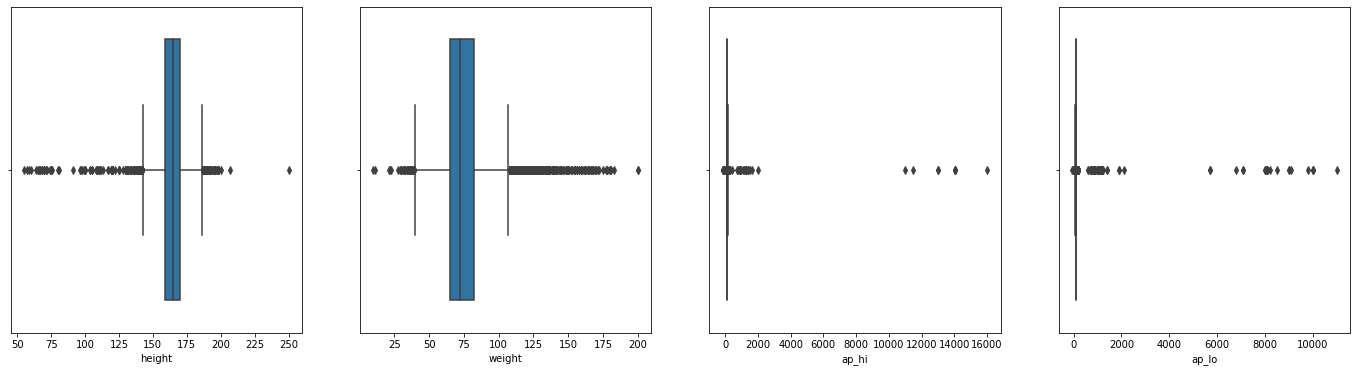

In [11]:
plt.figure(figsize = (24, 6));
plt.subplot(1, 4, 1)
sns.boxplot(data = df, x = 'height');
plt.subplot(1, 4, 2)
sns.boxplot(data = df, x = 'weight');
plt.subplot(1, 4, 3)
sns.boxplot(data = df, x = 'ap_hi');
plt.subplot(1, 4, 4)
sns.boxplot(data = df, x = 'ap_lo');

The boxes' widths equal IQR (InterQuartile Range), and the "whiskers" limit points that fall within the interval $[Q1 - 1.5 * IQR ; Q3 + 1.5 * IQR]$.
This interval has approximately 99.3 % of all observations.

Let us filter columns 'height', 'weight', 'ap_hi' and 'ap_lo' by the above interval so that we will exclude outliers.

In [12]:
boundaries = pd.DataFrame(columns = ['height', 'weight', 'ap_hi', 'ap_lo'],
                          index = ['lower_boundary', 'upper_boundary'])
for i in ['height', 'weight', 'ap_hi', 'ap_lo']:
  Q1, Q3 = df[i].quantile(0.25), df[i].quantile(0.75)
  IQR = iqr(df[i], rng = (25, 75))
  lower_boundary = Q1 - 1.5 * IQR
  upper_boundary = Q3 + 1.5 * IQR
  boundaries[i] = [lower_boundary, upper_boundary]
boundaries

,height,weight,ap_hi,ap_lo
lower_boundary,142.5,39.5,90.0,65.0
upper_boundary,186.5,107.5,170.0,105.0


So, for example, 99.3 % of all systolic blood pressure values ('ap_hi') in the dataset are within [90; 170].

Now we can filter our dataset according to the above conditions:

In [13]:
outliers = ((df < boundaries.iloc[0]) | (df > boundaries.iloc[1])).any(axis = 1)
df = df[~outliers]
#The second way to filter:
#for i in ['height', 'weight', 'ap_hi', 'ap_lo']:
  #df = df[(df[i] >= boundaries.loc['lower_boundary', i]) & (df[i] <= boundaries.loc['upper_boundary', i])]

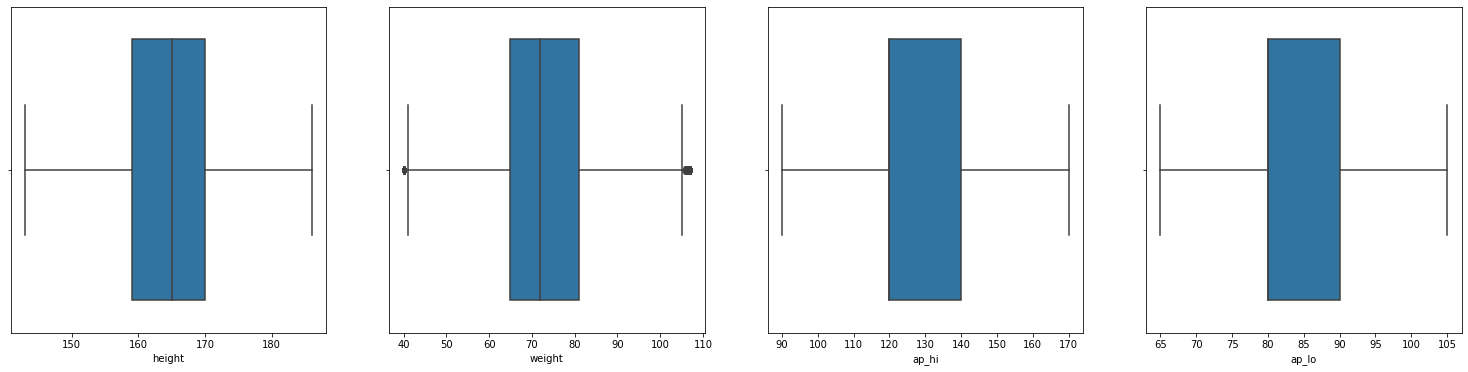

In [14]:
#Let's see the result of cleaning:
plt.figure(figsize = (26, 6));
plt.subplot(1, 4, 1)
sns.boxplot(data = df, x = 'height');
plt.subplot(1, 4, 2)
sns.boxplot(data = df, x = 'weight');
plt.subplot(1, 4, 3)
sns.boxplot(data = df, x = 'ap_hi');
plt.subplot(1, 4, 4)
sns.boxplot(data = df, x = 'ap_lo');

Now let's drop patients who have 'ap_lo' less than 'ap_hi':

In [15]:
df = df[~df['ap_hi'] < df['ap_lo']]
print('Cleaned dataset has shape: ', df.shape)

Cleaned dataset has shape:  (62505, 12)


Our data is clean now.

In [16]:
df.groupby('gender').agg({'height': 'mean'})

,height
gender,
1,161.557
2,169.732


Average '2' gender height is greater, therefore '2' is for male and '1' is for female.

In [17]:
gender = {1: 'female', 2: 'male'}
df['gender'] = df['gender'].replace(gender)
#Adding new feature 'bmi' - Body mass index:
df['bmi'] = df['weight'] / (df['height'] / 100) ** 2
#Adding new feature 'bmi_category':
df['bmi_category'] = np.where(df['bmi'] > 25, 1, 0)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bmi_category
0,50,male,168,62.0,110,80,1,1,0,0,1,0,21.967,0
1,55,female,156,85.0,140,90,3,1,0,0,1,1,34.928,1
2,52,female,165,64.0,130,70,3,1,0,0,0,1,23.508,0
3,48,male,169,82.0,150,100,1,1,0,0,1,1,28.710,1
5,60,female,151,67.0,120,80,2,2,0,0,0,0,29.385,1


According to the world standard, bmi_category = 1 is for overweight, and 0 - for normal body weight.
Body mass index is calculated as:

$bmi = \frac{weight}{(height / 100)^2}$

***Summarize:***
*   We have cleaned the data by $[Q1 - 1.5 * IQR ; Q3 + 1.5 * IQR]$ interval;
*   We have added 2 new features: 'bmi' and 'bmi_category'.

In [18]:
#df.to_excel('cardio_train_cleaned.xlsx')

### Vizualizations:
Plotting correlation matrix for the data:

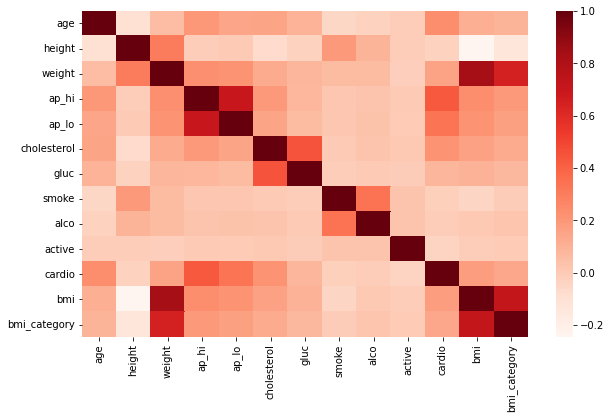

In [19]:
corrmap = df.corr()
plt.subplots(figsize = (10, 6))
sns.heatmap(corrmap, vmax = 1, square = False, cmap = 'Reds');

As we can see, none of the features clearly correlates with the other.

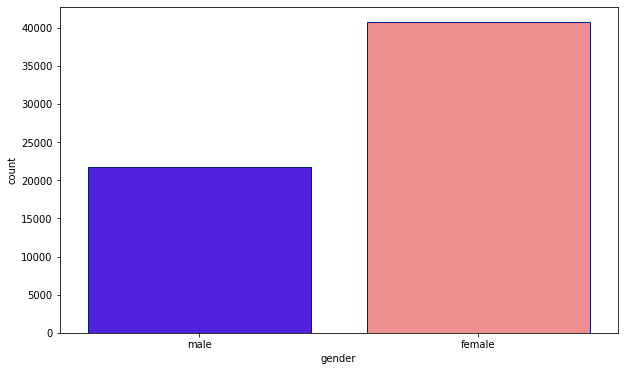

In [20]:
plt.subplots(figsize = (10, 6)) 
sns.countplot(data = df, x = 'gender', linewidth = 1, edgecolor = sns.color_palette('dark', 1), palette = 'gnuplot2');

Dataset's observations has approximately 2 times more women than men.

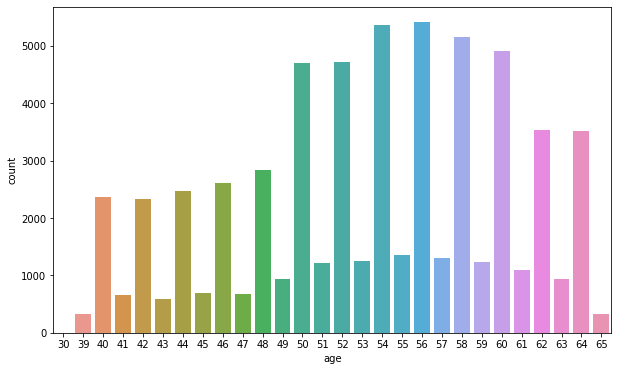

In [21]:
plt.subplots(figsize = (10, 6)) 
sns.countplot(data = df, x = 'age');

Seems like our observations are artificial, because of the above age distribution, alternating 'age' in step of 1.

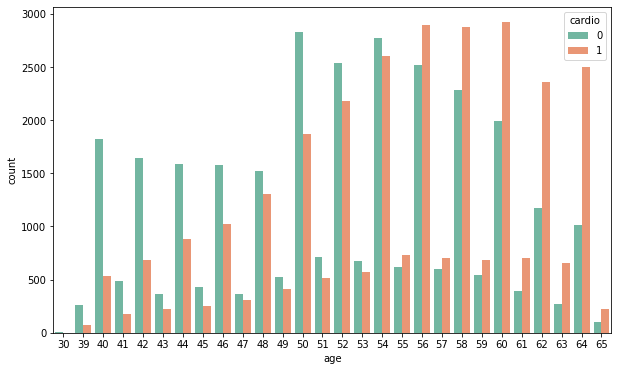

In [22]:
plt.subplots(figsize = (10, 6))
sns.countplot(data = df, x = 'age', hue = 'cardio', palette = 'Set2');

People over 50 are more exposed to CVD. 

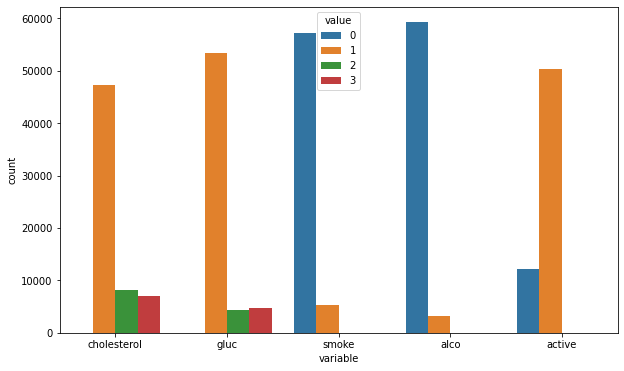

In [23]:
plt.subplots(figsize = (10, 6))
df_categorical = df.loc[:, ['cholesterol', 'gluc', 'smoke', 'alco', 'active']]
sns.countplot(x = 'variable', hue = 'value', data = pd.melt(df_categorical));

Most people have normal cholesterol and glucose levels. The vast majority do not drink alcohol. Most people are active.

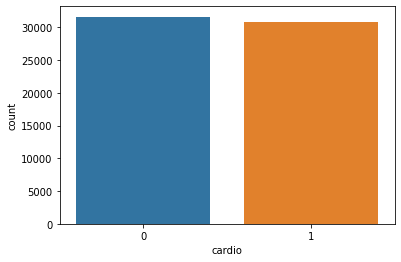

In [24]:
sns.countplot(data = df, x = 'cardio');

Class 'cardio' is well balanced.

**Few more conclusions:**

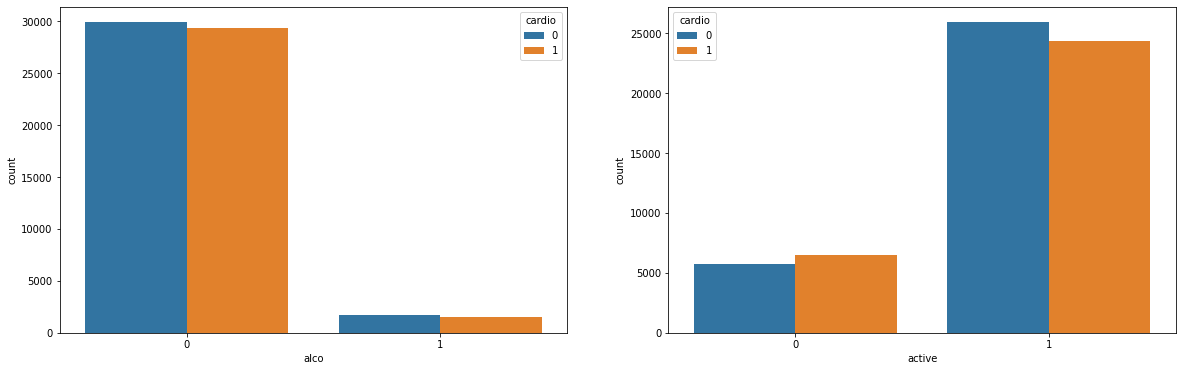

In [25]:
plt.figure(figsize = (20, 6));
plt.subplot(1, 2, 1)
sns.countplot(data = df, x = 'alco', hue = 'cardio');
plt.subplot(1, 2, 2)
sns.countplot(data = df, x = 'active', hue = 'cardio');

Well, the answer to the most frequent question related to CVD. According to our data, the above plots mean that alcohol lovers and non-drinkers have approximately equal chances to get diseased CVD. And the same conslusion for active and non-active people.

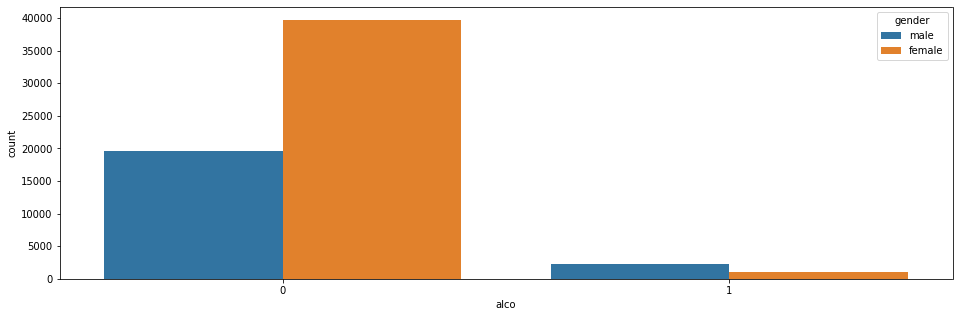

In [26]:
plt.figure(figsize = (16, 5));
sns.countplot(data = df, x = 'alco', hue = 'gender');

Men are more likely to drink alcohol than women.

In [27]:
print('Percentage of male smokers: {} %.'.format(round(len(df[(df['gender'] == 'male') & (df['smoke'] == 1)]) /
                                                 len(df[df['gender'] == 'male']) * 100, 1)))
print('Percentage of female smokers: {} %.'.format(round(len(df[(df['gender'] == 'female') & (df['smoke'] == 1)]) /
                                                 len(df[df['gender'] == 'female']) * 100, 1)))

Percentage of male smokers: 21.6 %.
Percentage of female smokers: 1.7 %.


There much fewer smokers among men.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


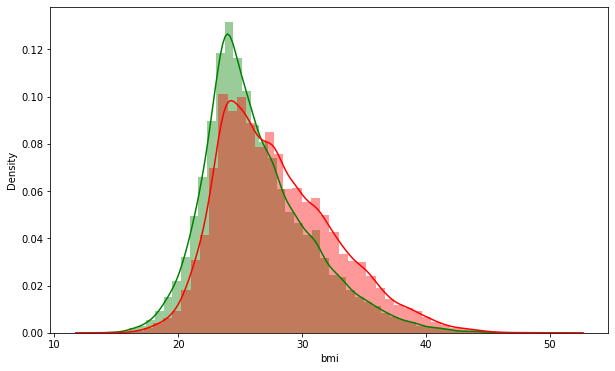

In [28]:
plt.subplots(figsize = (10, 6))
sns.distplot(df[df['cardio'] == 0]['bmi'], color = 'g');
sns.distplot(df[df['cardio'] == 1]['bmi'], color = 'r');

As we can see, patients have more chances to get disease when bmi is more than ~25.

In [29]:
#Encoding 'gender' values:
df = pd.get_dummies(df, columns = ['gender'])

###Modelling:

Let's build 3 the most popular classifiers: RandomForest, XGBClassifier and LGBMClassifier. Then we are going to compare their metrics.

In [30]:
X, y = df.drop('cardio', axis = 1), df['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3, shuffle = True)

In [ ]:
models = [RandomForestClassifier(), XGBClassifier(), LGBMClassifier()]
for model in models:
  model.fit(X_train, y_train);
  print('{}:'.format(type(model).__name__))
  print('Train dataset accuracy: {:.2f} %'.format(model.score(X_train, y_train) * 100))
  print('5-fold cross validation mean score: {:.2f} %'.format(np.mean(cross_val_score(model, X_train, y_train, cv = 5)) * 100))
  print('Test dataset accuracy: {:.2f} %'.format(model.score(X_test, y_test) * 100))
  print('ROC_AUC score: {:.3f}'.format(roc_auc_score(y_test, model.predict(X_test))))
  print('F1 score: {:.3f}'.format(f1_score(y_test, model.predict(X_test))))
  plot_roc_curve(model, X_test, y_test)
  plt.plot([0, 1], [0, 1])
  plt.show()
  print('\n')

RandomForestClassifier:
Train dataset accuracy: 97.52 %


In the issue, XGBClassifier has showed the best test result.

In [ ]:
def plot_feature_importances(model):
  features = X.columns
  importances = model.feature_importances_
  indices = np.argsort(importances)
  plt.title('Feature importances')
  plt.barh(range(len(indices)), importances[indices], color = 'b', align = 'center')
  plt.yticks(range(len(indices)), [features[i] for i in indices])
  plt.xlabel('Relative importance')
  plt.show()
for model in models:
  plt.figure(figsize = (14, 5));
  print('{}:'.format(type(model).__name__))
  plot_feature_importances(model)

Here we can see the most important features for the each of 3 classifiers. But, if a feature has low *feature_importance_* value for one of the above classifiers this does not mean, that it is uninformative. It more likely means, that it has been chosen by a tree, because another feature has the same infromation.

Unlike linear models' coefficients, importances of features does not indicate their relationship with a specific class.

Finally, this concludes my work with CVD dataset. Your comments and feedback are most welcome for me.